# Assessment for Advanced Data Science

## Christian Cabrera, Radzim Sendyka, Carl Henrik Ek and Neil D. Lawrence

### 6th November 2023



Welcome to the course assessment for the Advanced Data Science unit. In this assessment you will build a prediction system for UK house prices.

Your prediction system will be based on data from the UK Price Paid data available [here](https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads). By combining this data with the UK Office for National Statistics data on the latitude/longitude of postcodes (available [here](https://www.getthedata.com/open-postcode-geo)) you will have a record of house prices and their approximate latitude/longitude. Due to the size of these data you will use a relational database to handle them.  

To make predictions of the house price you will augment your data with information obtained from Open Street Map: an open license source of mapping information. You will use the techniques you have learnt in the course to indentify and incorporate useful features for house price prediction.



Alongside your implementation you will provide a short repository overview describing how you have implemented the different parts of the project and where you have placed those parts in your code repository. You will submit your code alongside a version of this notebook that will allow your examiner to understand and reconstruct the thinking behind your analysis. This notebook is structured to help you in creating that description and allow you to understand how we will allocate the marks. You should make use of the Fynesse framework (<https://github.com/lawrennd/fynesse_template>) for structuring your code.

Remember the notebook you create should *tell a story*, any code that is not critical to that story can safely be placed into the associated analysis library and imported for use (structured as given in the Fynesse template)

The maximum total mark for this assessment is 20. That mark is split into Three Questions below, each worth 5 marks each. Then a final 5 marks will be given for the quality, structure and reusability of the code and analysis you produce giving 20 marks in total. At the end, we would like to know your experience using LLMs in this assignment.

### Important Note:

*Some tasks in this assignment require you to develop skills for searching for multiple solutions and trying different things. This environment recreates industrial data science and software engineering problems. There is no one right answer.*


### Useful Links

You may find some of the following links useful when building your system.

University instuctions on Security and Privacy with AWS.

https://help.uis.cam.ac.uk/service/network-services/hosting-services/AWS/aws-security-privacy

Security Rules in AWS

https://docs.aws.amazon.com/AmazonRDS/latest/UserGuide/USER_VPC.Scenarios.html#USER_VPC.Scenario4

### Installing Your Library

One artefact to be included in your submission is a python library structured according to the "Access, Assess, Address" standard for data science solutions. You will submit this library alongside your code. Use the cell below to perform the necessary installation instructions for your library.

You should base your module on the template repository given by the Fynesse template repository. That should make it `pip` installable as below.



In [2]:
%pip install git+https://github.com/Isaac-d22/ADS_final_assignment.git
%pip install osmnx
%pip install pymysql

  Cloning https://github.com/Isaac-d22/ADS_final_assignment.git to /private/var/folders/k3/ghfh_db95gd3y5y75qb_s8v40000gn/T/pip-req-build-ovfci4xn
  Running command git clone --filter=blob:none --quiet https://github.com/Isaac-d22/ADS_final_assignment.git /private/var/folders/k3/ghfh_db95gd3y5y75qb_s8v40000gn/T/pip-req-build-ovfci4xn
  Resolved https://github.com/Isaac-d22/ADS_final_assignment.git to commit defcf10d5c6616090977c06f63412419c502cb31
  Preparing metadata (setup.py) ... done
  Created wheel for fynesse: filename=fynesse-0.1.0-py3-none-any.whl size=12084 sha256=8a128096d0f7bfc9e93826e9f7fd83ad7b19bbe154b62e56d5e7edf018eeb9d7
  Stored in directory: /private/var/folders/k3/ghfh_db95gd3y5y75qb_s8v40000gn/T/pip-ephem-wheel-cache-d59zfnus/wheels/22/39/ed/9473f89c6899e94676f4d315937d47b62eedba7b0c98049978
Successfully built fynesse

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to r

Your own library should be installed in the line above, then you can import it as usual (where you can either replace `fynesse` with the name you've given your analysis module or you can leave the name as `fynesse` as you prefer).

In [6]:
import datetime
import os
import time
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fynesse.access as access
import fynesse.assess as assess
import fynesse.address as address
from tqdm import tqdm
from sklearn.decomposition import PCA
from ipywidgets import interact_manual, Text, Password

## Question 1. Accessing a Database of House Prices, Latitudes and Longitudes

The UK price paid data for housing dates back to 1995 and contains millions of transactions. The size of the data makes it unwieldy to manipulate directly in python frameworks such as `pandas`. As a result we will host the data in a *relational database*.

Using the following ideas.

1. A cloud hosted database (such as MariaDB hosted on the AWS RDS service).
2. The SQL language wrapped in appropriately structured python code.
3. Joining of two databases.

You will construct a database containing tables that contain all house prices, latitudes and longitudes from the UK house price data base since 1995.

You will likely find the following resources helpful.

1. Lecture 1, 2 and 3.
2. Lab class 1 and 2.
3. The UK Price Paid data for houses: <https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads>
4. The UK ONS Data base of postcode latitude and longitudes:  <https://www.getthedata.com/open-postcode-geo>

Below we provide codeboxes and hints to help you develop your answer.

### Important Notes:

*The main knowledge you need to do a first pass through this question will have been taught by the end of Lab Session 2 (31st October 2023). You will likely want to review your answer as part of **refactoring** your code  and analysis pipeline shortly before hand in.*

*We recommend doing Question 1 as early as possible to avoid being blocked from important work given that uploading the data can take long.*

*If you encounter problems with the online notebook (e.g., interrupted connections with the AWS server), you can use a local IDE to work in your machine.*

*5 Marks*

### Task A

Set up the database. You'll need to set up a database on AWS. You were guided in how to do this in the lab sessions. You should be able to use the same database instance you created in the lab, or you can delete that and start with a fresh instance. You'll remember from the lab that the database requires credentials (username, password) to access. It's good practice to store those credentials *outside* the notebook so you don't accidentally share them by e.g. checking code into a repository.
  
Call the database you use for this assessment `property_prices`.
  

It is best practice not to expose credentials in code and so below I have included a means for the user to insert their credentials into a yaml file. This yaml file can then be read from to collect the details needed to establish a connection. Once the credentials have been obtained a connection can easily be establish via a simple API call and we use this connection to create the property_prices database below.

In [6]:
# Write code for requesting and storing credentials (username, password) here.
@interact_manual(username=Text(description="Username:"),
                 password=Password(description="Password:"))
def write_credentials(username, password):
    with open("credentials.yaml", "w") as file:
        credentials_dict = {'username': username,
                            'password': password,
                            'url': 'database-ads-id373.cgrre17yxw11.eu-west-2.rds.amazonaws.com',
                            'port': 3306,
                            'name': 'property_prices'
                            }
        yaml.dump(credentials_dict, file)

interactive(children=(Text(value='', continuous_update=False, description='Username:'), Password(continuous_up…

In [7]:
credentials = access.get_credentials("credentials.yaml")
username = credentials["username"]
password = credentials["password"]
url = credentials["url"]
port = credentials["port"]
db_name = credentials["name"]

In [5]:
conn = access.create_connection(user=username, password=password, host=url, port=port)
cursor = conn.cursor()
cursor.execute(f"CREATE DATABASE IF NOT EXISTS {db_name} DEFAULT CHARACTER SET utf8 COLLATE utf8_bin;")
conn.commit()

After creating the database I check to ensure that the query has actually been successful below by looking for the number of databases that have a similar name to property_prices, in our case this should be 1. It is also best practice to close database connections when you have finished using them and so I have made sure to do that below.

In [6]:
cursor.execute(f"SHOW DATABASES LIKE '{db_name}';")

1

In [7]:
cursor.close()
conn.close()

### Task B

Create a database table called `pp_data` containing all the UK Price Paid data from the [gov.uk site](https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads). You'll need to prepare a new table to receive the data and upload the UK Price Paid data to your database instance. The total data is over 3 gigabytes in size. We suggest that rather than downloading the full data in CSV format, you use the fact that they have split the data into years and into different parts per year. For example, the first part of the data for 2018 is stored at <http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-2018-part1.csv>. Each of these files is less than 100MB and can be downloaded very quickly to local disk, then uploaded using


```
LOAD DATA LOCAL INFILE 'filename' INTO TABLE `table_name`
FIELDS TERMINATED BY ',' OPTIONALLY ENCLOSED by '"'
LINES STARTING BY '' TERMINATED BY '\n';
```
*Note* this command should be wrapped and placed in an appropriately structured python module.

Each 'data part' should be downloadable from the `gov.uk` site. It should take around 5 minutes to download the whole dataset. By looping across the years and different parts, you should be able to robustly upload this large data set to your database instance in around 15 minutes. You should get a table with 28'258,161 rows. ***Note: A select count of the table can take more than half an hour.***

You may find the following schema useful in the creation of your table:

```
--
-- Table structure for table `pp_data`
--
DROP TABLE IF EXISTS `pp_data`;
CREATE TABLE IF NOT EXISTS `pp_data` (
  `transaction_unique_identifier` tinytext COLLATE utf8_bin NOT NULL,
  `price` int(10) unsigned NOT NULL,
  `date_of_transfer` date NOT NULL,
  `postcode` varchar(8) COLLATE utf8_bin NOT NULL,
  `property_type` varchar(1) COLLATE utf8_bin NOT NULL,
  `new_build_flag` varchar(1) COLLATE utf8_bin NOT NULL,
  `tenure_type` varchar(1) COLLATE utf8_bin NOT NULL,
  `primary_addressable_object_name` tinytext COLLATE utf8_bin NOT NULL,
  `secondary_addressable_object_name` tinytext COLLATE utf8_bin NOT NULL,
  `street` tinytext COLLATE utf8_bin NOT NULL,
  `locality` tinytext COLLATE utf8_bin NOT NULL,
  `town_city` tinytext COLLATE utf8_bin NOT NULL,
  `district` tinytext COLLATE utf8_bin NOT NULL,
  `county` tinytext COLLATE utf8_bin NOT NULL,
  `ppd_category_type` varchar(2) COLLATE utf8_bin NOT NULL,
  `record_status` varchar(2) COLLATE utf8_bin NOT NULL,
  `db_id` bigint(20) unsigned NOT NULL
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1 ;
```
This schema is written by Dale Potter and can be found on Github here: <https://github.com/dalepotter/uk_property_price_data/blob/master/create_db.sql>

You may also find it helpful to set up the following primary key to the `pp_data` table. This should be done before uploading your data.

```
--
-- Primary key for table `pp_data`
--
ALTER TABLE `pp_data`
ADD PRIMARY KEY (`db_id`);

ALTER TABLE `pp_data`
MODIFY db_id bigint(20) unsigned NOT NULL AUTO_INCREMENT, AUTO_INCREMENT=1;
```

In the box below, briefly describe what the schema is doing.

First a check is performed to determine whether a pp_data table already exists and if it does, it drops (i.e. deletes) that table from the database. The schema itself defines the fields of the table which are simply a one-to-one mapping with the columns in the csv. Each of these columns is given a type (i.e. int(10) which corresponds to an unsigned integer with a maximum value of 10 decimal digits, 4294967295 to be precise). The NOT NULL constraint that you see means that records cannot be inserted if they have a NULL value in this field and so for this schema all fields must be populated. COLLATE defines the set of rules used for string ordering and comparison in this schema utf8_bin is used. The DEFAULT here simply specifies what character set and collation function should be used if one hasn't been specified for a text field.

Below there is code that downloads the house price data from 1995 (when records began) all the way up to 2023 in parts. There are 2 parts per year and these csv's are stored in a house_price_data directory. Once the house price data has been downloaded I create the pp_data table and set it's primary key. After this, I populate the pp_data table by year, both the downloading of the data and the populating of the database can be time consuming so I include a visual progress bar to allow the user to see how far along they are with the respective process. I then query the database and check that the primary key (db_id) goes up to 30.5 million, this a faster way of checking the number of records in the database as this key increments by 1 for each row in the table. 30.5 million is more than the 28.25 million expected entries but this is likely due to the fact that I have included 2023 data here. Given the recent regime shift in interest rates (which is a feature that is not directly captured anywhere in our data) this more recent data could be particularly useful when trying to predict house prices in 2022 and 2023.

In [6]:
# Code to download the files in parts and store them in a directory
if not os.path.exists("house_price_data"):
    os.makedirs("house_price_data")
    
URL_PREFIX = "http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/"
for i in tqdm(range(1995, 2024)):
    part1 = f"pp-{i}-part1.csv"
    part2 = f"pp-{i}-part2.csv"
    access.download_csv(url=(URL_PREFIX + part1), filename=part1, target_dir="house_price_data")
    access.download_csv(url=(URL_PREFIX + part2), filename=part2, target_dir="house_price_data")

100%|██████████| 29/29 [04:50<00:00, 10.01s/it]


In [14]:
conn = access.create_connection(user=username, password=password, host=url, port=port, database=db_name)
access.create_pp_data(conn)
conn.close()

In [18]:
# Code to populate pp_data table with downloaded csv data
conn = access.create_connection(user=username, password=password, host=url, port=port, database=db_name)
for i in tqdm(range(1995, 2024)):
    part1 = f"house_price_data/pp-{i}-part1.csv"
    part2 = f"house_price_data/pp-{i}-part2.csv"
    access.populate_table(conn=conn, filename=part1, table="pp_data")
    access.populate_table(conn=conn, filename=part2, table="pp_data")
conn.close()

  0%|          | 0/29 [00:00<?, ?it/s]

100%|██████████| 29/29 [14:20<00:00, 29.66s/it]


In [19]:
conn = access.create_connection(user=username, password=password, host=url, port=port, database=db_name)
access.query_table(conn=conn, table='pp_data', conditions=[access.equal_condition('db_id', 30500000)])

(('{FAC30767-09BA-5E20-E053-4704A8C004EE}',
  229000,
  datetime.date(2023, 3, 7),
  'E17 4GD',
  'F',
  'N',
  'L',
  'CANNOCK COURT, 3',
  'FLAT 69',
  'HAWKER PLACE',
  '',
  'LONDON',
  'WALTHAM FOREST',
  'GREATER LONDON',
  'A',
  'A',
  30500000),)

In [20]:
conn.close()

### Task C

Create a database table called `postcode_data` containing the ONS Postcode information. <GetTheData.com> has organised data derived from the UK Office for National Statistics into a convenient CSV file. You can find details [here](https://www.getthedata.com/open-postcode-geo).


The data you need can be found at this url: <https://www.getthedata.com/downloads/open_postcode_geo.csv.zip>. It will need to be unzipped before use. Downloading and unzipping the data should not take more than 10 seconds.

You may find the following schema useful for the postcode data (developed by Christian and Neil)

```
USE `property_prices`;
--
-- Table structure for table `postcode_data`
--
DROP TABLE IF EXISTS `postcode_data`;
CREATE TABLE IF NOT EXISTS `postcode_data` (
  `postcode` varchar(8) COLLATE utf8_bin NOT NULL,
  `status` enum('live','terminated') NOT NULL,
  `usertype` enum('small', 'large') NOT NULL,
  `easting` int unsigned,
  `northing` int unsigned,
  `positional_quality_indicator` int NOT NULL,
  `country` enum('England', 'Wales', 'Scotland', 'Northern Ireland', 'Channel Islands', 'Isle of Man') NOT NULL,
  `latitude` decimal(11,8) NOT NULL,
  `longitude` decimal(10,8) NOT NULL,
  `postcode_no_space` tinytext COLLATE utf8_bin NOT NULL,
  `postcode_fixed_width_seven` varchar(7) COLLATE utf8_bin NOT NULL,
  `postcode_fixed_width_eight` varchar(8) COLLATE utf8_bin NOT NULL,
  `postcode_area` varchar(2) COLLATE utf8_bin NOT NULL,
  `postcode_district` varchar(4) COLLATE utf8_bin NOT NULL,
  `postcode_sector` varchar(6) COLLATE utf8_bin NOT NULL,
  `outcode` varchar(4) COLLATE utf8_bin NOT NULL,
  `incode` varchar(3)  COLLATE utf8_bin NOT NULL,
  `db_id` bigint(20) unsigned NOT NULL
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin;
```

And again you'll want to set up a primary key for the new table.

```
ALTER TABLE `postcode_data`
ADD PRIMARY KEY (`db_id`);

ALTER TABLE `postcode_data`
MODIFY `db_id` bigint(20) unsigned NOT NULL AUTO_INCREMENT,AUTO_INCREMENT=1;
```

And you can load the CSV file into the table using this command.

```
LOAD DATA LOCAL INFILE 'open_postcode_geo.csv' INTO TABLE `postcode_data`
FIELDS TERMINATED BY ',' OPTIONALLY ENCLOSED by '"'
LINES STARTING BY '' TERMINATED BY '\n';
```

As in Task B I once again download the csv data and store it locally. However this time the dataset is signifcantly smaller so i just download it in one go and then extract it from the associated zip file. I then create the postcode_data table and set its associated primary key follwoing the schema above. I then populate the table and query it to check that the population was successful.

In [ ]:
# code to download and extract zip file
if not os.path.exists("postcode_data"):
    os.makedirs("postcode_data")
access.download_csv(url="https://www.getthedata.com/downloads/open_postcode_geo.csv.zip", filename="open_postcode_geo.csv.zip", target_dir="postcode_data", extract=True)

In [ ]:
conn = access.create_connection(user=username, password=password, host=url, port=port, database=db_name)
access.create_postcode_data(conn)
conn.close()

In [ ]:
conn = access.create_connection(user=username, password=password, host=url, port=port, database=db_name)
access.populate_table(conn=conn, filename="postcode_data/open_postcode_geo.csv", table="postcode_data")
conn.close()

In [8]:
# Check to ensure that postcode data has been populated in teh relevant table
conn = access.create_connection(user=username, password=password, host=url, port=port, database=db_name)
access.query_table(conn=conn, table='postcode_data', conditions=[access.equal_condition('db_id', 2500000)])

(('WA8 8TU',
  'live',
  'small',
  348820,
  384408,
  1,
  'England',
  Decimal('53.35406500'),
  Decimal('-2.77037600'),
  'WA88TU',
  'WA8 8TU',
  'WA8  8TU',
  'WA',
  'WA8',
  'WA8 8',
  'WA8',
  '8TU',
  2500000),)

In [ ]:
conn.close()

### Task D

This table should contain the house price paid and the latitude and longitude of the house. We could create a new data frame that contains all this information. However, the computation of that data frame would take some time because of the size of the two existing tables in the join. Whether this is a good idea or not in a live system will depend on how often these predictions are required. If it's very often, it would be better to store the join as a new table in the database, because the one-off cost for that join is amortised across all the future predictions. If only a few predictions are required (like in our lab class) then doing that join on the fly might be better.

- Option A: Think about which columns from each table will be useful to you in making predictions, then write code to efficiently select this information and create a data frame from the two tables for a set of properties. "Join on the fly". This option looks easier but the disadvantage is the extra latency it adds as joins are performed every time we need to answer data questions. These latencies are usually not accepted in production environments.

- Option B: Alternatively, you can create a database table called `property_prices` to store the join of the tables you created in the previous tasks. The advantage of this approach is that you will get faster responses because the join is performed once. The disadvantage is that populating the new table can take a long time because you would join two big tables. You need to be more creative with this option. Remember that you can divide your dataset by different criteria (e.g., by year) and that loading data from files is much faster than `INSERT INTO` instructions. Populating the table took from 4 to 6 minutes per year in our tests on a Dell Laptop Intel Core i5 with 16GB of RAM and using the Eduroam network at the Computer Lab. Populating the table by year also gives you control over the upload process. You could write your code in a way you can stop and restart the upload process. The new table could have a schema like the one below:

  ```
  USE `property_prices`;
  --
  -- Table structure for table `prices_coordinates_data`
  --
  DROP TABLE IF EXISTS `prices_coordinates_data`;
  CREATE TABLE IF NOT EXISTS `prices_coordinates_data` (
    `price` int(10) unsigned NOT NULL,
    `date_of_transfer` date NOT NULL,
    `postcode` varchar(8) COLLATE utf8_bin NOT NULL,
    `property_type` varchar(1) COLLATE utf8_bin NOT NULL,
    `new_build_flag` varchar(1) COLLATE utf8_bin NOT NULL,
    `tenure_type` varchar(1) COLLATE utf8_bin NOT NULL,
    `locality` tinytext COLLATE utf8_bin NOT NULL,
    `town_city` tinytext COLLATE utf8_bin NOT NULL,
    `district` tinytext COLLATE utf8_bin NOT NULL,
    `county` tinytext COLLATE utf8_bin NOT NULL,
    `country` enum('England', 'Wales', 'Scotland', 'Northern Ireland', 'Channel Islands', 'Isle of Man') NOT NULL,
    `latitude` decimal(11,8) NOT NULL,
    `longitude` decimal(10,8) NOT NULL,
    `db_id` bigint(20) unsigned NOT NULL
  ) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1 ;

  ```

In both cases you will need to perform a join between `pp_data` and `postcode_data` tables. Joining large tables without the right indexes in place will take a long time. You should think and set the right index for an efficient join. Indexing the `pp_data` table should take less than 5 minutes, while it takes less than one minute to index the `postcode_data` table.

Note that there is no preference for either approach in the mark scheme.

You should use the joined data in your prediction model in Question 3. Exploit the nature of the task to use prices for a particular region in a given period. This means we can select the relevant rows from the database according to that region and period.

***After you have populated your database tables and created the functions to access the data you need for Question 3, you will not need to redo any of the previous steps. If at some point you find the AWS database is not responding or taking longer than expected to perform operations, you can have a look at the process list and kill the one are causing problems. If killing the processes does not work, you should reboot the database in the AWS console. Be careful with other database instances if you need to reboot your database. Also, be careful not to delete the database instead of rebooting it. If you delete the database, it is likely you will need to redo all Question 1.***

Here I decide to with option B and create a table called prices_coordinates_data, the reasoning being that my machine is a bit underpowered so doing the join live when modelling would be too slow. Additionally, given that in our case our database is static (i.e. additional data is not being inserted into it) this join will only have to be done once so I thought this was a better representation of what would be more likely to occur in a production system. I start of by creating the prices_coordinates_data table, I then proceed to create indexes for the pp_data and postcode_data tables to facilitate faster joining. After this, I proceed to join the tables by year and store the joined data in a csv locally. The extraction process supports pausing as and partial completion as if a file for that year aready exists it will go on to the next year and as you can see I paused my extraction at the 12th year below. I then populate the table by year which is a lot faster than extracting the joined data (to be expected given that no joins need to be completed). I then check to see that the data has been successfully uploaded to the prices_coordinates table and index on latitude, longitude and date_of_transfer to help training set extraction in task 3

In [3]:
# Write the code you used to join the tables, or the code you used to join on the fly.
conn = access.create_connection(user=username, password=password, host=url, port=port, database=db_name)
access.create_prices_coordinates_data(conn)
conn.close()

In [21]:
# Indexing pp_data table on postcode
conn = access.create_connection(user=username, password=password, host=url, port=port, database=db_name)
access.create_index(conn, 'index_postcode', 'pp_data', 'postcode')
conn.close()

In [22]:
# Indexing pp_data table on date_of_transfer
conn = access.create_connection(user=username, password=password, host=url, port=port, database=db_name)
access.create_index(conn, 'index_date_of_transfer', 'pp_data', 'date_of_transfer')
conn.close()

In [ ]:
# Indexing postcode_data table on postcode
conn = access.create_connection(user=username, password=password, host=url, port=port, database=db_name)
access.create_index(conn, 'index_postcode', 'postcode_data', 'postcode')
conn.close()

In [23]:
# Extract join data from database and store in csv locally
# Added a check so that it does not re-extract data that has already been extracted
if not os.path.exists("joined_data"):
    os.makedirs("joined_data")

conn = access.create_connection(user=username, password=password, host=url, port=port, database=db_name)
for year in tqdm(range(1995, 2024)):
      if f"{year}.csv" in os.listdir('joined_data'):
            continue
      access.store_joined_data(conn, year)
conn.close()

 41%|████▏     | 12/29 [21:52<30:58, 109.34s/it]

2006 took: 1312.0737240314484 seconds


 45%|████▍     | 13/29 [42:40<1:01:27, 230.48s/it]

2007 took: 1248.0671701431274 seconds


 48%|████▊     | 14/29 [48:42<1:01:57, 247.84s/it]

2008 took: 362.0547139644623 seconds


 52%|█████▏    | 15/29 [53:58<1:00:22, 258.76s/it]

2009 took: 316.67065691947937 seconds


 55%|█████▌    | 16/29 [1:00:10<1:00:34, 279.56s/it]

2010 took: 371.3548822402954 seconds


 59%|█████▊    | 17/29 [1:06:16<59:31, 297.61s/it]  

2011 took: 366.0408709049225 seconds


 62%|██████▏   | 18/29 [1:12:26<57:36, 314.23s/it]

2012 took: 369.9284951686859 seconds


 66%|██████▌   | 19/29 [1:21:46<1:02:30, 375.10s/it]

2013 took: 560.53963804245 seconds


 69%|██████▉   | 20/29 [1:35:45<1:14:23, 495.92s/it]

2014 took: 838.1714642047882 seconds


 72%|███████▏  | 21/29 [1:46:10<1:10:47, 531.00s/it]

2015 took: 625.1107277870178 seconds


 76%|███████▌  | 22/29 [1:53:57<59:52, 513.25s/it]  

2016 took: 467.4768750667572 seconds


 79%|███████▉  | 23/29 [2:02:08<50:40, 506.83s/it]

2017 took: 490.75059366226196 seconds


 83%|████████▎ | 24/29 [2:09:52<41:12, 494.46s/it]

2018 took: 464.1165518760681 seconds


 86%|████████▌ | 25/29 [2:16:53<31:31, 472.87s/it]

2019 took: 420.67240715026855 seconds


 90%|████████▉ | 26/29 [2:23:21<22:23, 447.80s/it]

2020 took: 387.81659412384033 seconds


 93%|█████████▎| 27/29 [2:38:05<19:14, 577.32s/it]

2021 took: 884.8639860153198 seconds


 97%|█████████▋| 28/29 [3:20:23<19:20, 1160.28s/it]

2022 took: 2537.28449010849 seconds


100%|██████████| 29/29 [3:26:52<00:00, 428.01s/it] 

2023 took: 389.1440660953522 seconds


In [7]:
conn = access.create_connection(user=username, password=password, host=url, port=port, database=db_name)
for year in tqdm(range(1995,2024)): 
        start = time.time()
        file_path = f"joined_data/{year}.csv"
        access.populate_table(conn=conn, filename=file_path, table="prices_coordinates_data")
        end = time.time()
        print(f"{year} took: {end-start} seconds")
conn.close()

  3%|▎         | 1/29 [00:13<06:28, 13.89s/it]

1995 took: 13.886062860488892 seconds


  7%|▋         | 2/29 [00:30<06:57, 15.46s/it]

1996 took: 16.557843923568726 seconds


 10%|█         | 3/29 [00:52<07:55, 18.30s/it]

1997 took: 21.668492078781128 seconds


 14%|█▍        | 4/29 [01:31<11:03, 26.54s/it]

1998 took: 39.14479207992554 seconds


 17%|█▋        | 5/29 [02:02<11:15, 28.15s/it]

1999 took: 30.985936880111694 seconds


 21%|██        | 6/29 [02:18<09:16, 24.21s/it]

2000 took: 16.577188730239868 seconds


 24%|██▍       | 7/29 [02:50<09:46, 26.64s/it]

2001 took: 31.60731792449951 seconds


 28%|██▊       | 8/29 [03:16<09:17, 26.57s/it]

2002 took: 26.412975072860718 seconds


 31%|███       | 9/29 [03:37<08:14, 24.72s/it]

2003 took: 20.6515109539032 seconds


 34%|███▍      | 10/29 [04:21<09:43, 30.69s/it]

2004 took: 44.042025089263916 seconds


 38%|███▊      | 11/29 [04:36<07:46, 25.92s/it]

2005 took: 15.0917649269104 seconds


 41%|████▏     | 12/29 [05:21<08:56, 31.59s/it]

2006 took: 44.5473530292511 seconds


 45%|████▍     | 13/29 [06:17<10:25, 39.09s/it]

2007 took: 56.33937621116638 seconds


 48%|████▊     | 14/29 [06:38<08:25, 33.69s/it]

2008 took: 21.209630012512207 seconds


 52%|█████▏    | 15/29 [06:52<06:28, 27.73s/it]

2009 took: 13.873190879821777 seconds


 55%|█████▌    | 16/29 [07:05<05:02, 23.30s/it]

2010 took: 13.007625102996826 seconds


 59%|█████▊    | 17/29 [07:17<03:59, 19.96s/it]

2011 took: 12.193318128585815 seconds


 62%|██████▏   | 18/29 [07:53<04:29, 24.49s/it]

2012 took: 35.02468395233154 seconds


 66%|██████▌   | 19/29 [08:11<03:46, 22.67s/it]

2013 took: 18.42741084098816 seconds


 69%|██████▉   | 20/29 [08:32<03:18, 22.09s/it]

2014 took: 20.746530771255493 seconds


 72%|███████▏  | 21/29 [08:52<02:52, 21.55s/it]

2015 took: 20.2942111492157 seconds


 76%|███████▌  | 22/29 [09:32<03:09, 27.14s/it]

2016 took: 40.158628702163696 seconds


 79%|███████▉  | 23/29 [10:00<02:43, 27.24s/it]

2017 took: 27.469801902770996 seconds


 83%|████████▎ | 24/29 [10:18<02:02, 24.56s/it]

2018 took: 18.292673110961914 seconds


 86%|████████▌ | 25/29 [10:32<01:25, 21.34s/it]

2019 took: 13.836617946624756 seconds


 90%|████████▉ | 26/29 [11:16<01:24, 28.13s/it]

2020 took: 43.9685800075531 seconds


 93%|█████████▎| 27/29 [11:41<00:54, 27.27s/it]

2021 took: 25.250776767730713 seconds


 97%|█████████▋| 28/29 [12:00<00:24, 24.92s/it]

2022 took: 19.435594081878662 seconds


100%|██████████| 29/29 [12:09<00:00, 25.15s/it]

2023 took: 8.375259160995483 seconds


In [8]:
# Checking that table entries are reasonable after conversion to a dataframe
conn = access.create_connection(user=username, password=password, host=url, port=port, database=db_name)
x = access.query_table(conn, 'prices_coordinates_data')
conn.close()
access.price_coordinates_data_to_df(x)

price date_of_transfer  postcode property_type new_build_flag tenure_type  \
0   17000       1995-01-01   HU5 5NY             T              N           F   
1  105000       1995-01-01  GU35 8NR             S              N           F   
2   50000       1995-01-01  CT19 6HL             S              N           F   
3  165500       1995-01-01   B45 8LY             D              N           F   
4   50000       1995-01-01   BS1 6XF             F              N           L   
5   72000       1995-01-01  SK10 5HS             S              N           F   
6  300000       1995-01-01  SW19 5JU             F              Y           L   
7   53250       1995-01-01   M24 4EN             S              N           L   
8   43000       1995-01-01  IP13 9BY             T              N           F   
9   80000       1995-01-01   CR3 5SU             D              N           F   

       locality     town_city            district              county  \
0          HULL          HULL  KINGSTON UPON HULL          HUMBERSIDE   
1  HEADLEY DOWN        BORDON      EAST HAMPSHIRE           HAMPSHIRE   
2    FOLKESTONE    FOLKESTONE             SHEPWAY                KENT   
3   BARNT GREEN    BIRMINGHAM          BROMSGROVE      WORCESTERSHIRE   
4       BRISTOL       BRISTOL             BRISTOL                AVON   
5    BOLLINGTON  MACCLESFIELD        MACCLESFIELD            CHESHIRE   
6        LONDON        LONDON              MERTON      GREATER LONDON   
7     MIDDLETON    MANCHESTER            ROCHDALE  GREATER MANCHESTER   
8   FRAMLINGHAM    WOODBRIDGE     SUFFOLK COASTAL             SUFFOLK   
9      CATERHAM      CATERHAM           TANDRIDGE              SURREY   

   country     latitude    longitude  db_id  
0  England  53.75367500  -0.41398500      1  
1  England  51.11642600  -0.81124800      2  
2  England  51.09171500   1.18352700      3  
3  England  52.36307800  -1.98116500      4  
4  England  51.44725900  -2.61388400      5  
5  England  53.29541900  -2.11429700      6  
6  England  51.43432600  -0.22373100      7  
7  England  53.55471400  -2.21635700      8  
8  England  52.22133600   1.35248100      9  
9  England  51.29164500  -0.09533700     10

In [198]:
# Indexing joint table on date to aid with training data collection in the prediction stage
conn = access.create_connection(user=username, password=password, host=url, port=port, database=db_name)
access.create_index(conn, 'index_date_of_transfer', 'prices_coordinates_data', 'date_of_transfer')
conn.close()

In [199]:
# Indexing joint table on latitude to aid with training data collection in the prediction stage
conn = access.create_connection(user=username, password=password, host=url, port=port, database=db_name)
access.create_index(conn, 'index_latitude', 'prices_coordinates_data', 'latitude')
conn.close()

In [200]:
# Indexing joint table on longitude to aid with training data collection in the prediction stage
conn = access.create_connection(user=username, password=password, host=url, port=port, database=db_name)
access.create_index(conn, 'index_longitude', 'prices_coordinates_data', 'longitude')
conn.close()

In [9]:
conn = access.create_connection(user=username, password=password, host=url, port=port, database=db_name)
cursor = conn.cursor()
cursor.execute("""SHOW INDEXES FROM prices_coordinates_data""")
x = cursor.fetchall()
print(x)
cursor.close()
conn.close()

(('prices_coordinates_data', 0, 'PRIMARY', 1, 'db_id', 'A', 26894910, None, None, '', 'BTREE', '', '', 'NO'), ('prices_coordinates_data', 1, 'index_date_of_transfer', 1, 'date_of_transfer', 'A', 148590, None, None, '', 'BTREE', '', '', 'NO'), ('prices_coordinates_data', 1, 'index_latitude', 1, 'latitude', 'A', 2444991, None, None, '', 'BTREE', '', '', 'NO'), ('prices_coordinates_data', 1, 'index_longitude', 1, 'longitude', 'A', 2444991, None, None, '', 'BTREE', '', '', 'NO'))


## Question 2. Accessing OpenStreetMap and Assessing the Available Features

In question 3 you will be given the task of constructing a prediction system for property price levels at a given location. We expect that knowledge of the local region around the property should be helpful in making those price predictions. To evaluate this we will now look at [OpenStreetMap](https://www.openstreetmap.org) as a data source.

The tasks below will guide you in accessing and assessing the OpenStreetMap data. The code you write will eventually be assimilated in your python module, but documentation of what you've included and why should remain in the notebook below.

Accessing OpenStreetMap through its API can be done using the python library `osmx`. Using what you have learned about the `osmx` interface in the lectures, write general code for downloading points of interest and other relevant information that you believe may be useful for predicting house prices. Remembering the perspectives we've taken on *data science as debugging*, the remarks we've made when discussing *the data crisis* of the importance of reusability in data analysis, and the techniques we've explored in the labsessions for visualising features and exploring their correlation use the notebook to document your assessment of the OpenStreetMap data as a potential source of data.

The knowledge you need to do a first pass through this question will have been taught by end of lab session three (16th November 2021). You will likely want to review your answer as part of *refactoring* your code and analysis pipeline shortly before hand in.

You should write reusable code that allows you to explore the characteristics of different points of interest. Looking ahead to question 3 you'll want to incorporate these points of interest in your prediction code.

*5 marks*


In [ ]:
# Use this cell and cells below for summarising your analysis and documenting your decision making.

OSM has an extremely wide range of features available, a lot of which are seen as being positively correlated with house prices (e.g. public transport and schools in the local area). There are also features that one would expect to negatively correlated with house prices such as waste and flood prone areas. Below I have tried to take a mix of both (though admittedly it was easier to come up with 'positive features'). I then visualise these features on a map across 3 significanlty different area (King Cross, Cornwall and Cambridge) to see how these features manifest themselves physically. 

Rather than simply encoding whether a given tag is present in the local area I thought a better feature would be to compute counts of each of the feature type for the are in question. I then look at the distribution of these counts across a set of randomly chosen locations from the database to get a better idea of the sparsity of these features. I also look at the cross correlations for these features to better udnerstand the cross-sectionality of these features.

Lastly, I apply PCA to the features and then visualise the principle components in 1, 2 and 3 dimensions to see if I can make sense of the relationships I am seeing. 

## Feature selection and visualisation

As I mentioned above OSM has a wide range of features to chose from, however given that we I will be making use of relatively simple models I thought it would be best to make use of a feature set that has a high level of interpretability and where the reasoning behind the inclusion of each feature is clear. With that in mind, I propose the following set of features:<br>
* Public transport - For a significant proportion of the population (school kids and working adults) the availability of public transport close to their home is of high importance as they use it very frequently, this is more true in large cities such as London and Manchester but it is also a factor in suburban areas where people commute in to cities for work frequently. 
* Amenity - Proximity to things such as restaurants, cinemas etc. also are a key factor when people are where to buy a house as having things to do in your local area is valuable.
* Leisure - Areas such as parks and playgrounds are also quite important considerations (especially for families) as having these nearby provides convenience to the home owner.
* Natural - Similarly the amount of nature in the local area is also important as people generally prefer to have places where they can go on walks and runs, or just to be able to take in the scenary around them
* Shop - Living close to shops is quite important (everybody needs groceries) and so having one withing walking distance offers the home owner convenience.
* Tourism - If the area is seen as touristic this is typically a good signal for property prices as it signal more demand for holiday lets and short term stays.
* Historic - Similarly if an area is classed as historic this also indicates that there will be more demand for short term stays which should drive the price up.
* Aeroway - This could be both a negative and a positive, for people that need to travel frequently it could be a positive as it makes their travelling more convenient. However for the average person it could be a negative due to the noise pollution associated with planes.
* Healthcare - Access to healthcare locally is helpful (especially for older people) as it makes frequent visits less time consuming.
* Industrial - This classifies industrial areas which is liekly to be a negative signal for property prices as living close to factories or other industrial sites typically comes with signifanct levels of pollution and disturbances.
* Flood prone - Being close to lots of flood prone areas is also likely to be a negative signal for property prices do to the increased risk of flooding and inconvenience and cost of a flood.
* Highway - Potentially a benefit as it signals faster travel by car, however it could also be seen as a negative due to the noise pollution.
* Waste - Proximity to waste is likely to be a negative due to the smell and other issues associated with it.
* School - For families this is normally one of the most important factors as having to drive to pick up kids vs walk makes a massive difference to day-to-day life. <br>

In [25]:
KEYS_DICT = {
        "public_transport": True,
        "amenity": True, 
        "leisure": True, 
        "natural": True, 
        "landuse:residential": True,
        "shop": True,
        "tourism": True,
        "historic": True,
        "aeroway": True,
        "healthcare": True,
        "industrial": True,
        "flood_prone": True,
        "highway": True,
        "waste": True
        }

KEYS = ["public_transport", "amenity", "leisure", "natural", "shop", "tourism", 
             "historic", "aeroway", "healthcare", "industrial", "flood_prone", "highway", "waste"]
TAGS = [("amenity", "school")]

Let's visualise these features for Kings Cross, Cornwall and Cambridge (3 areas that are quite distinct from one another). As you can see there are some quite significant differences between the 3. Look at the historic tag for example, King Cross appears to have significantly more areas designated as historic when compared to Cambridge and Cornwall (this makes sense given that Kings Cross is located in the centre of the capital city). Kings Cross also appears to ahve significantly more amentities than Cornwall and Cambridge likely owing to the fact that it is seen as a relatively trendy area and has lots of young workers in the area that are looking for things to do after work. <br>

None of the 3 areas have any flood prone, industrial or aeroway areas suggesting that these are likely to be sparse features. 

Kings Cross, London has no aeroway keys
Kings Cross, London has no industrial keys
Kings Cross, London has no flood_prone keys
Cornwall, England has no aeroway keys
Cornwall, England has no industrial keys
Cornwall, England has no flood_prone keys
Cornwall, England has no waste keys
Cambridge, England has no aeroway keys
Cambridge, England has no industrial keys
Cambridge, England has no flood_prone keys


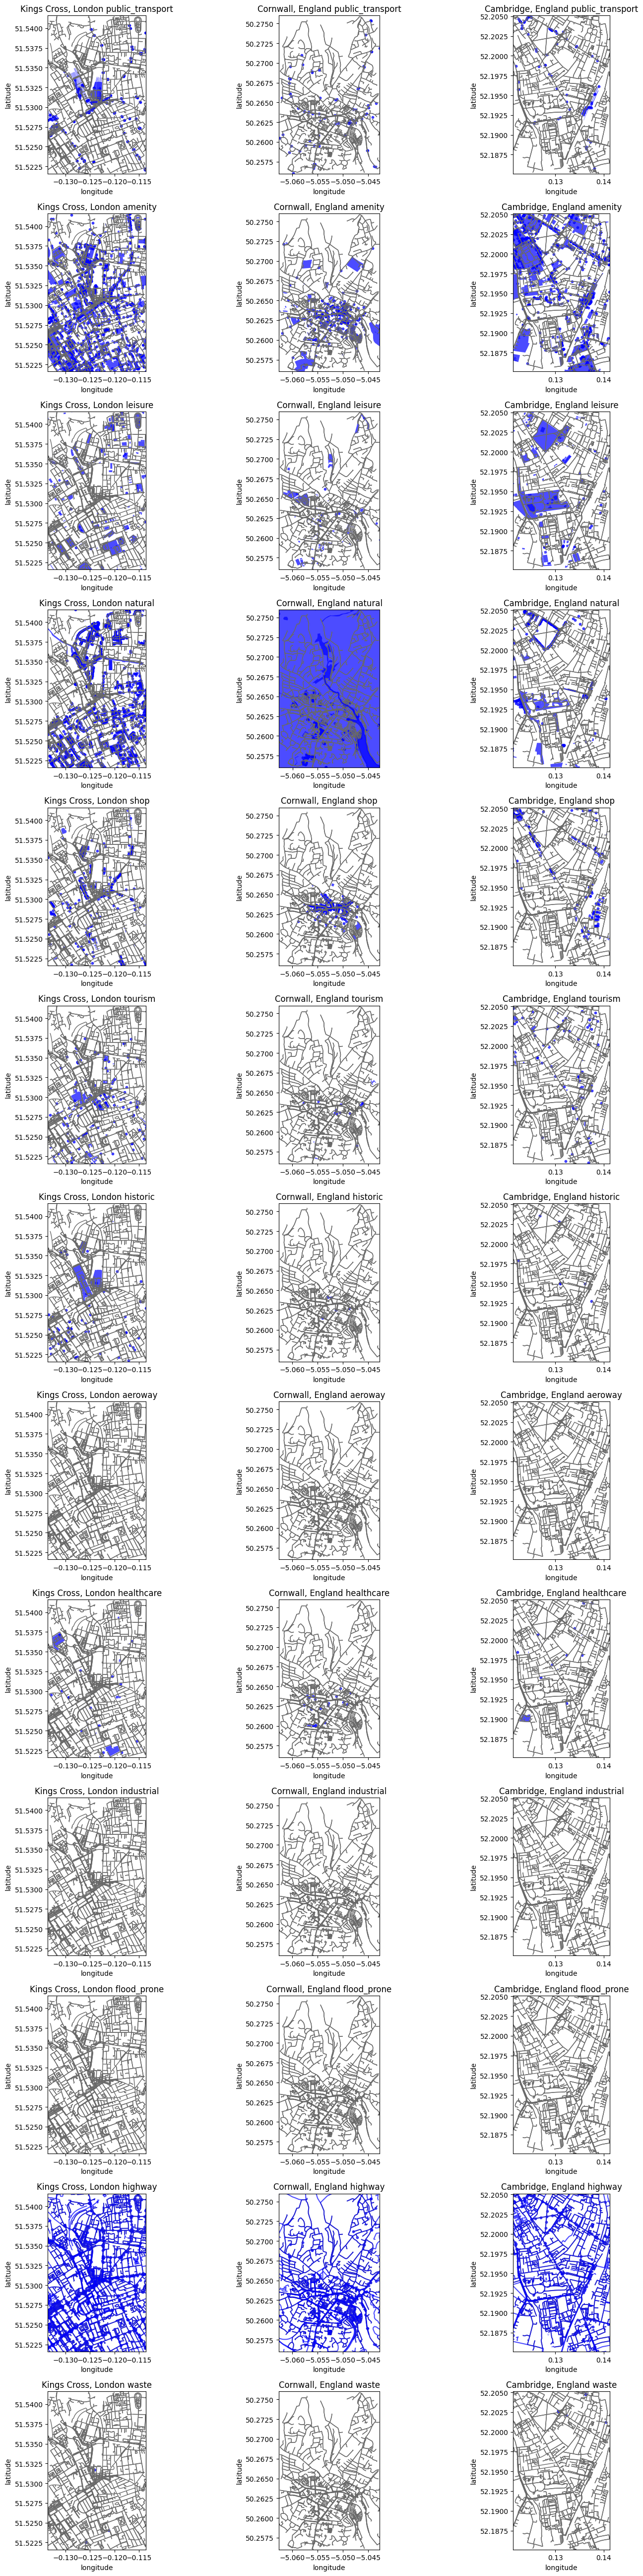

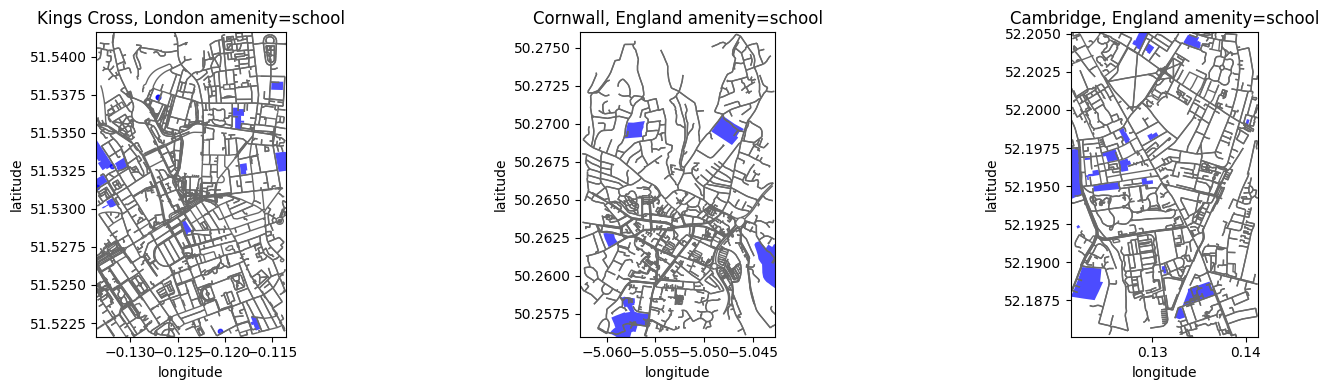

In [26]:
locations = [(51.5316, -0.1236, "Kings Cross, London"), (50.2660, -5.0527, "Cornwall, England"), (52.1951, 0.1313, "Cambridge, England")]
assess.visualise_pois_by_key(locations, KEYS)
assess.visualise_pois_by_key(locations, TAGS, tag_version=True)

## Feature distribution

Now let's take a look at how counts of the features are distributed across a set of random locations to get a better idea of the sparsity of the features. I also include price here as I believe understanding the price distribution will also be informative.

In [9]:
# Selecting a random set of rows from the database
conn = access.create_connection(user=username, password=password, host=url, port=port, database=db_name)
rows = access.get_random_rows(conn)
conn.close()
rows


price date_of_transfer  postcode property_type new_build_flag  \
0    46250       1995-09-29   NN2 8HT             S              N   
1    76000       1996-04-02   RH2 0JW             T              N   
2    95500       1996-05-31  RM12 6PX             S              N   
3    49995       1996-10-27   M23 9WH             S              N   
4    98500       1997-01-06  BS24 9JL             D              N   
..     ...              ...       ...           ...            ...   
92  770000       2022-03-30  YO18 7QZ             D              N   
93  157950       2022-07-01  LN13 9DF             S              Y   
94  290000       2022-09-22  OX29 4EX             T              N   
95  370000       2022-11-01   RM3 9AF             T              N   
96  347000       2022-11-04  NP10 9NS             S              N   

   tenure_type           locality          town_city              district  \
0            F        NORTHAMPTON        NORTHAMPTON           NORTHAMPTON   
1            F            REIGATE            REIGATE  REIGATE AND BANSTEAD   
2            F         HORNCHURCH         HORNCHURCH              HAVERING   
3            L         MANCHESTER         MANCHESTER            MANCHESTER   
4            F  WESTON-SUPER-MARE  WESTON-SUPER-MARE        NORTH SOMERSET   
..         ...                ...                ...                   ...   
92           F   THORNTON-LE-DALE          PICKERING               RYEDALE   
93           F                                ALFORD          EAST LINDSEY   
94           F            EYNSHAM             WITNEY      WEST OXFORDSHIRE   
95           F                               ROMFORD              HAVERING   
96           F         ROGERSTONE            NEWPORT               NEWPORT   

                county  country     latitude    longitude     db_id  
0     NORTHAMPTONSHIRE  England  52.26659700  -0.91291300    588128  
1               SURREY  England  51.24586600  -0.18037500   1034063  
2       GREATER LONDON  England  51.55799900   0.23174100   1174706  
3   GREATER MANCHESTER  England  53.39782200  -2.30259100   1606034  
4       NORTH SOMERSET  England  51.31542900  -2.96006700   1840133  
..                 ...      ...          ...          ...       ...  
92     NORTH YORKSHIRE  England  54.23705900  -0.70754100  28532013  
93        LINCOLNSHIRE  England  53.25319500   0.17929600  28777328  
94         OXFORDSHIRE  England  51.78663600  -1.36965200  28984437  
95      GREATER LONDON  England  51.61041000   0.22075000  29098109  
96             NEWPORT    Wales  51.58769700  -3.06146800  29104166  

[97 rows x 14 columns]

In [11]:
pois_by_features = assess.get_pois_for_rows(rows)

As we can see below pretty much all the features are postively skewed. That being said public_transport and school seem to have the least skew visually whilst aeroway and flood_prone exhibit the most skew. This seems to at least be partly due to the sparsity of the aerorway and flood_prone features as each appear to only have a few entries. Price also exhibits quite a signifcant skew but this is more likely due to the fact that we have selected an outlier for price (a value between 2.5 and 3 million). Also when modelling we will be calculating these features across houses within some area so the ditributions should become less skewed as they wont be a random subset of all the houses in the UK as we have here.

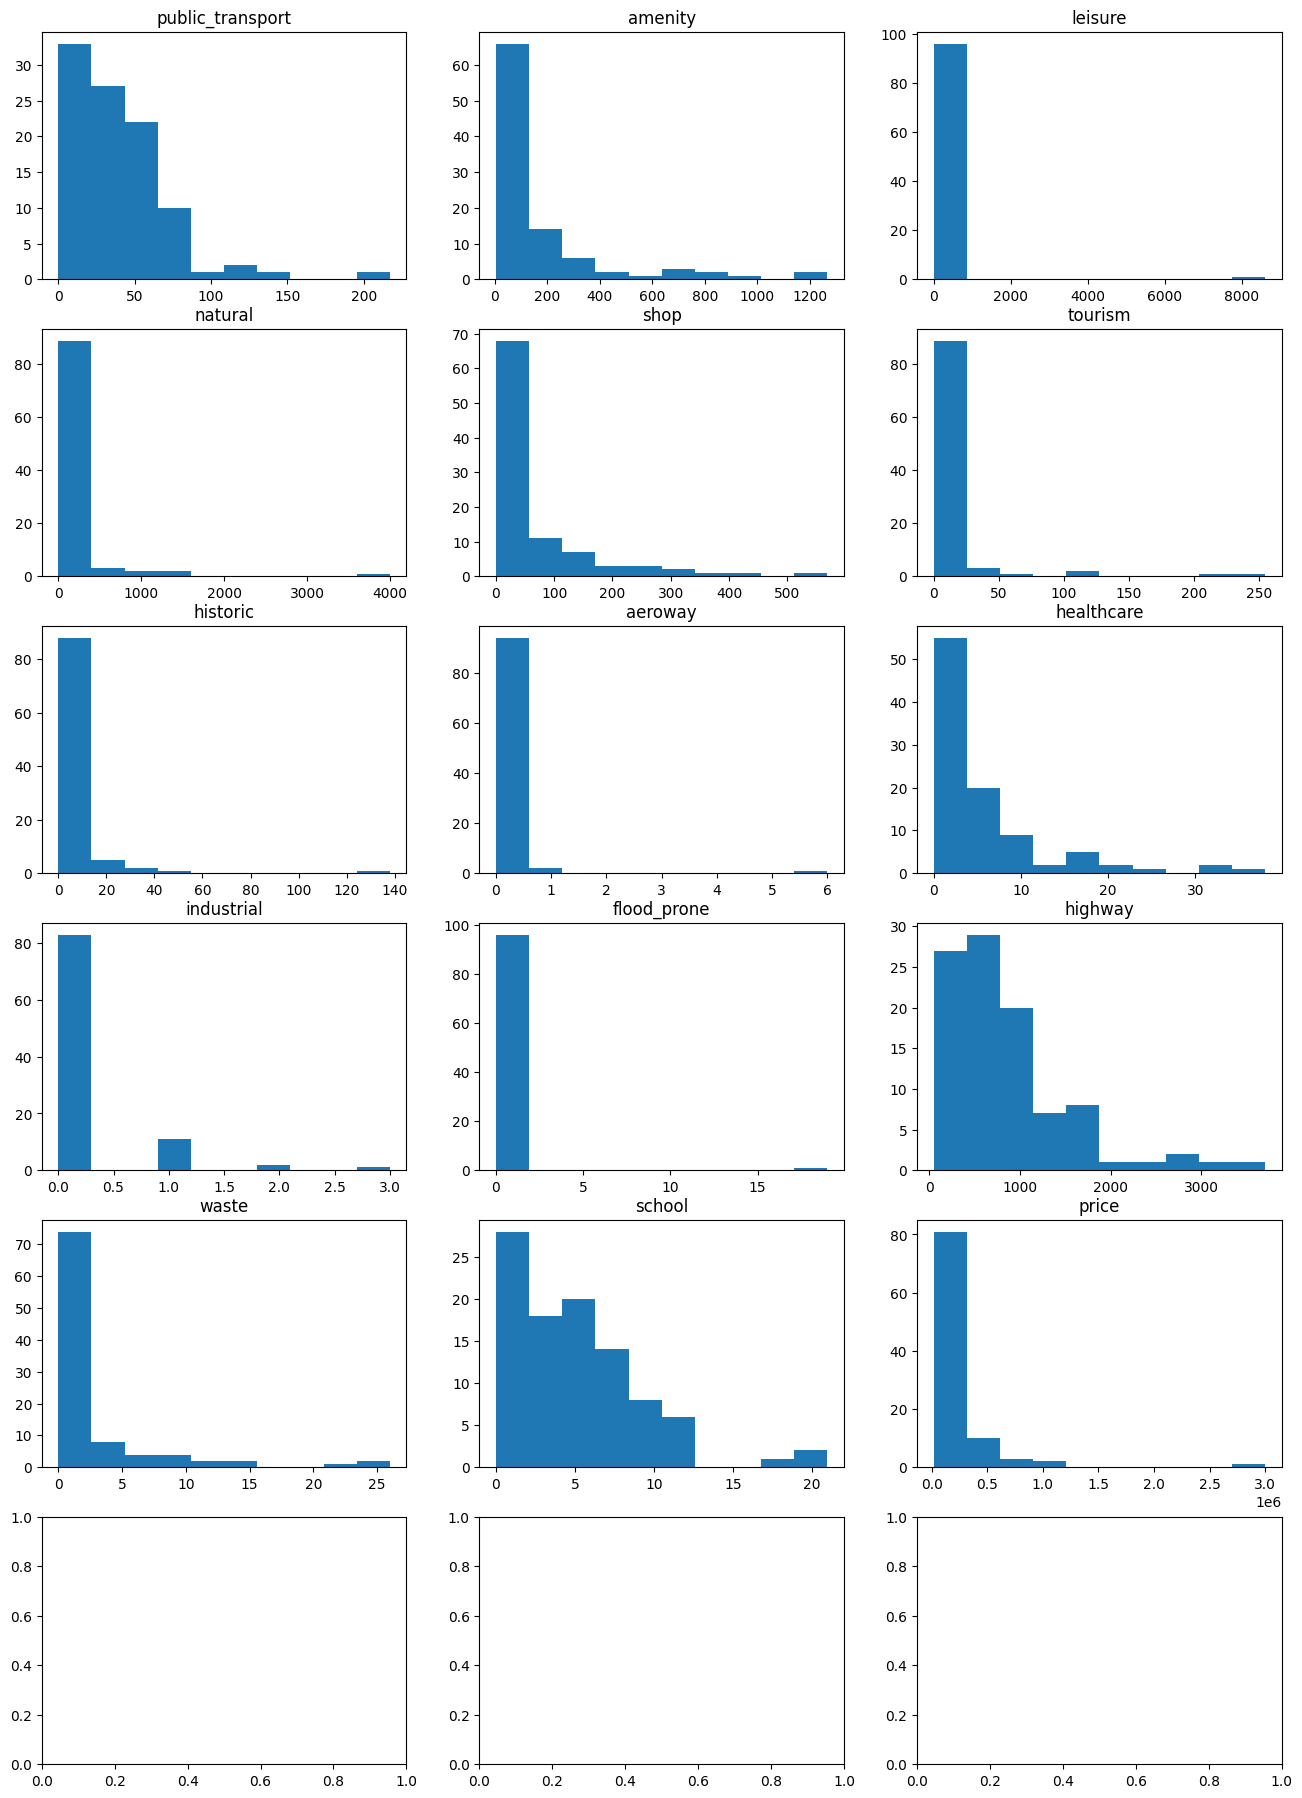

In [12]:
assess.visualise_feature_dist(pois_by_features)

## Correlations

Lets now take a look at the corss sectionality of our different features as well as how correlated they are with price. As we can see below a significant amount of the features are highly correlated with each other. This is to be expected, naturally amenities and shops will be close to one another and historic areas are old and so more liekly to be flood prone. That being said none of the features have a very high correlation with price, the best we see is amenity at 0.135 and industrial at -0.137. Surprisingly, waste seems to be positively correlated with price which goes against the prior that I had for selecting it as a feature.

In [13]:
df = pd.DataFrame(pois_by_features)
corr = df.corr()
corr.style.background_gradient(cmap='Reds')

## PCA

Now let's do PCA to see the relative importance of different features in terms of expressing the variability across the data we have. We drop price here as we won't be including it as a feature and are instead intrested in how we can summarise our feature set more efficiently. As we can see a signle principle component only summaries just over half of our variance and this increases to 96.5% when we make use of 6 principal components.

The explained variance with 1 principle componnts is: 0.5536911261292775
The explained variance with 2 principle componnts is: 0.7315775026849286
The explained variance with 3 principle componnts is: 0.8440969735793459
The explained variance with 4 principle componnts is: 0.9103244845292627
The explained variance with 5 principle componnts is: 0.9419195145998234
The explained variance with 6 principle componnts is: 0.964921489528632


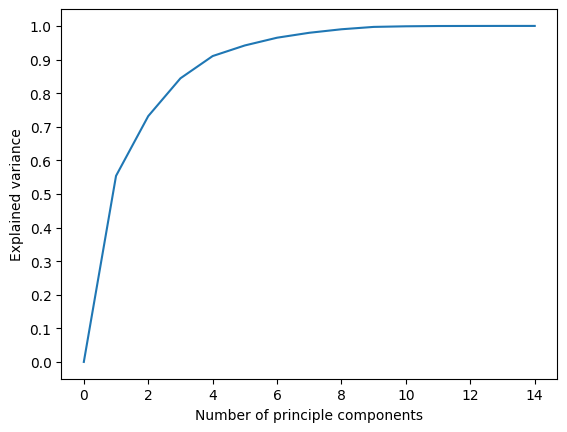

In [14]:
corr = corr.drop('price')
corr = corr.drop('price', axis=1)
pca = PCA(n_components=len(corr))
princ_compt = pca.fit_transform(corr)
explained_variance = np.concatenate([np.array([0]), np.cumsum(pca.explained_variance_ratio_)])
cutoff = np.argmax(explained_variance > 0.95)
for i in range(1, cutoff + 1):
    print(f"The explained variance with {i} principle componnts is: {explained_variance[i]}")
plt.ylabel('Explained variance')
plt.xlabel('Number of principle components')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.plot(explained_variance)
plt.show()

Now lets try to visualise our principle components to see what relationships they are capturing. Visualising a 6-dimensional space isn't easy so let's visualise 1, 2 and 3 principle components instead

In [15]:
COLOURS = ['black', 'red', 'darkorange', 'gold', 'yellow', 'darkolivegreen', 'lime', 'silver',
           'aquamarine', 'dodgerblue', 'purple', 'fuchsia', 'lightpink', 'peru']

Below we can see the 1st principle component visualisation which captures about 55% of our variance. That being said, these relationships aren't the easiest to make sense of with a lot of our points being clustered in small regions.

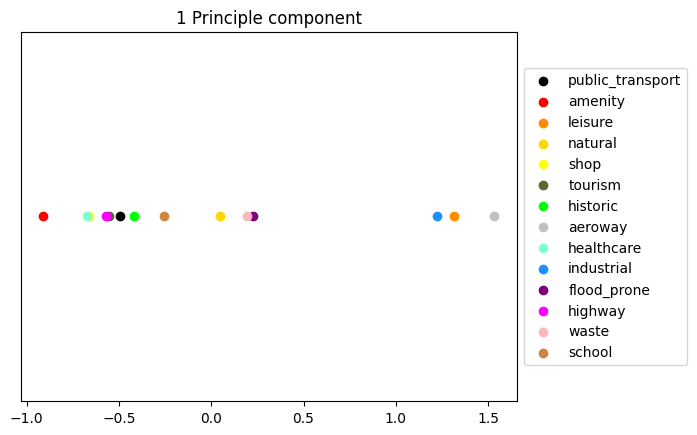

In [17]:
# 1 principle component
assess.vis_PCA1(corr, princ_compt)

If we look at a 2 principle component visualition the picture becomes a bit clearer which is expected as we now have about 73% of our variance being explained. As you can see the closest mapping is between highway and healthcare which makes sense given that hospitals are normally located in areas that are easy to access via a vehicle and we saw a storng correlation between the 2 earlier of 0.67. That being said not all relationships make sense take a look at leisure and aeroway which had a -0.02 correlation between them, yet here they are clustered together.

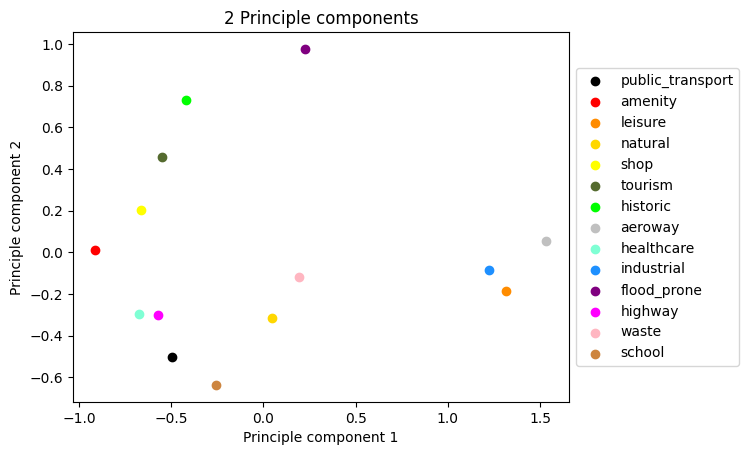

In [18]:
# 2 principle components
assess.vis_PCA2(corr, princ_compt)

Now taking a look at a 3 principle component visualisation the situation has improved once again. With more of our strong relationships being clustered together such as tourism and historic. That being said this visualisation can be decieving given that the lines are not equally spaced and it can be hard to tell the exact position of a point.

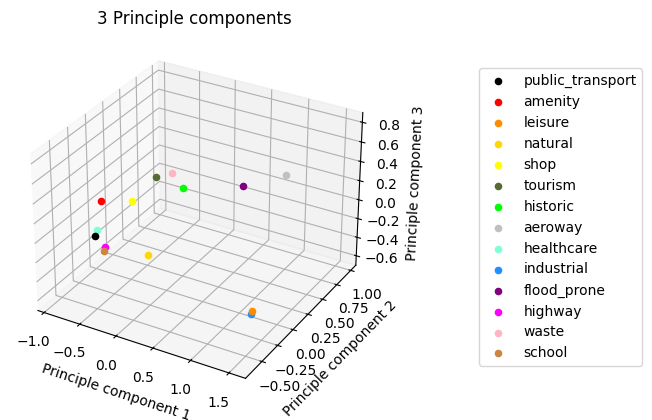

In [19]:
# 3 principle components
assess.vis_PCA3(corr, princ_compt)

## Question 3. Addressing a Property Price Prediction Question

For your final tick, we will be asking you to make house price predictions for a given location, date and property type in the UK. You will provide a function that takes input a latitude and longitude as well as the `property_type` (either type" of property (either `F` - flat, `S` - semidetached, `D` - detached, `T` - terraced or `O` other). Create this function in the `address.py` file, for example in the form,

```
def predict_price(latitude, longitude, date, property_type):
    """Price prediction for UK housing."""
    pass
```

We suggest that you use the following approach when building your prediction.

1. Select a bounding box around the housing location in latitude and longitude.
2. Select a data range around the prediction date.
3. Use the data ecosystem you have build above to build a training set from the relevant time period and location in the UK. Include appropriate features from OSM to improve the prediction.
4. Train a linear model on the data set you have created.
5. Validate the quality of the model.
6. Provide a prediction of the price from the model, warning appropriately if your validation indicates the quality of the model is poor.

Please note that the quality of predictions is not the main focus of the assignment - we expect to see models that output reasonable predictions and have positive R^2's, but you should not spend too much time on increasing the model's accuracy.

The knowledge you need to do a first pass through this question will have been taught by end of lab session four (7th November 2023). You will likely want to review your answer as part of *refactoring* your code shortly before hand in.



House prices typically move quite slowly (at least when compare to other asset class such as equities), even in the 2007 crisis it took around 2 years for property prices to reach their bottom. For this reason a large date range (potentially +-6 months) could be quite informative. However this needs to be balanced witht the speed of preidction and because of this I have gone with a default date range of +-4 weeks from the date of transfer, however this can be modified by the user depending on their exact situation (i.e. are they in a meeting and need a prediction in 30s or do they have more time on their hands and the ability to wait 30 minutes for a prediction). 
<br><br>
As for bounding box range this is a bit different. In highly urbanised areas like London there is typically a greater level of income disparity and because of this the size of the area should not be too big. That being said in more rural areas this is less of an isssue and so to strike a balance, I have gone with a bounding box of +-2 km for training samples. In order to get feature variation, the bounding box used for extracting OSM features should be smaller than the area used to select training samples from and so for simplicity I have gone with a bounding box of +-1 km here, which I am using to denote reasonable walking distance from a house. 
<br><br>
Additionally, I have excluded houses of types different to that of the one we wish to predict from the training samples as in order encoding this reasonably would require a one-hot-encoding which would introduce 5 additional features and whilst there is undoubtably some predictive information in other house types house prices, my prior is that simplifying the feature space here will be more beneficial given that we only need to make a single prediction for a house price that is not of the other types. That being said, I will be adding new_build_flag (wheteher a property is a new build or not) and freehold_flag (whether a property is a freehold or not) as features as these can drastically impact price. The new build premium is considered to be about 20% of the value of the property and a leasehold can make a property sell for significanlty less especially if that lease is considered 'short' as banks wont lend on a 'short' leasehold property.
<br><br>
To simplify the feature space dynamically depending on the charecteristics of the given location, I will be using PCA. This will allow me to extract features that are orthogonal meaning that the individual effects of each feature can be interpreted better and that the model will be more numerically stable due to less redundant information being captured. The dimensionality of my feature set will also be reduced whilst maintaining an explained variance of over 95% (by default) helping to simplify the model.
<br><br>
As for the model used to make the prediction, I give the user 2 options (classic linear regression or ridge regression). I have chosen to keep the models simple here whilst still offering the user the opportunity to penalise the L2 norm of the weights. To evaluate the model I include 3 metrics: the average percent error using cross-fold validation, the percentage error of the actual price we predict and the correlation of the models predictions with the actual house prices during cross validation. The hope is that these 3 metrics will assess the models performance in different ways (percent error corresponds to how well we predict our target, the average percent error during cross validation assesses whetehr this is likely our preidction happens to be good by chance or if it consistently good for other houses in the training set and the correlation assess how well our predicted points fit our regression line). It should be noted that the average error during cross validation is expected to be higher than that of the actual prediction as the date range and area bounds are centered on the target house and date.

## User options

First let's take a look at how the prediction performs with different date ranges used. Below I predict the price of a detached house in Orpington, London on the 03-05-2022 using a training date range of +-14, 28 and 42 days respectively. As we can see here the model using a date range of +-14 performs best in terms of the predicted value for the house we were looking at. That being said, it does have the worst average percentage area during cross validation so it is not clear that the quality of this prediction is not simply by chance. It also does have a respectable correlation 0.63 with the 9 samples in its date range. Based on the metrics calculated I would expect the model using +- 28 days for prediction to be the best as it has the highest correlation with price, an average cross-val error of 14.6% (which is a lot lower than the other 2 models) and a prediction percentage error that is respectable. However, it should be noted tt the sample sizes here are small and so it is unlikely that there is a statistcally signifcant difference between the models.

In [2]:
address.predict_price(51.363264, 0.090873, datetime.date(2022,5,3), 'D', date_range=14)
address.predict_price(51.363264, 0.090873, datetime.date(2022,5,3), 'D', date_range=28)
address.predict_price(51.363264, 0.090873, datetime.date(2022,5,3), 'D', date_range=42)

Number of training samples: 9
Extracting pois
Predicted: 751183.7997704416, Actual: 775000, Percentage error: 3.073058094136567%, Average percentage error: 26.45344942157315, Model correlation: 0.6342729165278053
Number of training samples: 22
Extracting pois
Predicted: 742095.0004367939, Actual: 775000, Percentage error: 4.2458063952524006%, Average percentage error: 14.5636687203707, Model correlation: 0.6860547280498513
Number of training samples: 26
Extracting pois
Predicted: 708120.1019876482, Actual: 775000, Percentage error: 8.6296642596583%, Average percentage error: 23.47898903350244, Model correlation: 0.5031462610474656


(708120.1019876482, 775000, 23.47898903350244, 0.5031462610474656)

Now let's take a look at how the prediction performs with different area ranges being used. Below I use the same house and date as before and set a bounding box of +-0.01, 0.02 and 0.03 degrees for training data extraction. The bounding box for OSM features is fixed at +-0.01 degrees (approximately 1km) in all 3 cases. As we can see the area range used seems to have a very big impact on the quality of our predictions. The 0.01 degree model produces predictions which have a strong negative correlation with prices during cross validation and the average error is very high at 43%. Despite this, the prediction error is only 5% showing the imprtance of including the different metrics I have included as 1 by itself could lead to a misrepresentation of the actual performance of the model. I believe the main issue with the 0.01 degree case is that the bounding box for the OSM features is the same size meaning that the tag counts extracted are likely to be quite similar across the whole training set which will lead to feature set that is not very expressive. The training set size is also very small (only 7) and so the impact of outliers will be more pronounced here. In the 0.03 degree model we get a model that has pretty much no correlation with house prices and still quite a bad average error. The reasoning for this is a bit different. The house I chose is located close to a gated community called Keston park where the house prices are significantly higher than prices for houses outside the community, the first 2 models do not have an area range big enough to pick up any houses in that community however the 3rd one does and so this will massively skew the house prices seen in training leading to the over prediction we see.

In [3]:
address.predict_price(51.363264, 0.090873, datetime.date(2022,5,3), 'D', area_range=0.01)
address.predict_price(51.363264, 0.090873, datetime.date(2022,5,3), 'D', area_range=0.02)
address.predict_price(51.363264, 0.090873, datetime.date(2022,5,3), 'D', area_range=0.03)

Number of training samples: 7
Extracting pois
Predicted: 733480.890354064, Actual: 775000, Percentage error: 5.357304470443362%, Average percentage error: 43.202858743919734, Model correlation: -0.6012677319776062
Number of training samples: 22
Extracting pois
Predicted: 742095.0004367939, Actual: 775000, Percentage error: 4.2458063952524006%, Average percentage error: 14.5636687203707, Model correlation: 0.6860547280498513
Number of training samples: 35
Extracting pois
Predicted: 910085.6631868931, Actual: 775000, Percentage error: 17.430408153147496%, Average percentage error: 29.74025261984635, Model correlation: -0.01645699483545195


(910085.6631868931, 775000, 29.74025261984635, -0.01645699483545195)

## Different model types

As I mentioned, the user also has the option to choose what type of model is used out of linear and ridge regression and they have the ability to set the associated penalty for the ridge. Let's look at how different ridge values effect our model for the orpington house. As we can see, in this case the application of a ridge seems beneficial to our model with our prediction error going down and our correlation being slightly up. That being said it is possible for the ridge penalty to become too severe, as we see in the case where a penalty of 10 is applied as our model performs worse across all metrics. The reason this occurs is because ridge regression penalises the square of our weights meaning that large weights are penalised leading the model to allocate more weight to weaker features and if this is done too much we end up underweighting our most important features.

In [2]:
address.predict_price(51.363264, 0.090873, datetime.date(2022,5,3), 'D')
address.predict_price(51.363264, 0.090873, datetime.date(2022,5,3), 'D', penalty=0.5)
address.predict_price(51.363264, 0.090873, datetime.date(2022,5,3), 'D', penalty=1)
address.predict_price(51.363264, 0.090873, datetime.date(2022,5,3), 'D', penalty=2)
address.predict_price(51.363264, 0.090873, datetime.date(2022,5,3), 'D', penalty=10)

Number of training samples: 22
Extracting pois
Predicted: 742095.0004367938, Actual: 775000, Percentage error: 4.245806395252416%, Average percentage error: 14.56366872037071, Model correlation: 0.6860547280498515
Number of training samples: 22
Extracting pois
Predicted: 749944.3890812008, Actual: 775000, Percentage error: 3.232982054038604%, Average percentage error: 14.294114099777744, Model correlation: 0.6927505634741628
Number of training samples: 22
Extracting pois
Predicted: 757526.1533202332, Actual: 775000, Percentage error: 2.254689894163455%, Average percentage error: 14.140959636456593, Model correlation: 0.6941196555490803
Number of training samples: 22
Extracting pois
Predicted: 770961.3905468563, Actual: 775000, Percentage error: 0.5211108971798282%, Average percentage error: 13.944198174303338, Model correlation: 0.691717309964213
Number of training samples: 22
Extracting pois
Predicted: 827848.0419147818, Actual: 775000, Percentage error: 6.819102182552489%, Average pe

(827848.0419147818, 775000, 14.64036647229453, 0.6455589353139505)

## Different locations

Let's now take a look at how the prediction function performs on homes from the 3 areas we used in part 2 (Kings Cross, Cambridge and Cornwall). As we see below, the models seem to perform alright at predicting the prices (a low of 7.3% error and a high of 15.8%) with the ridge regression actually performing slightly worse for Cambridge and Cornwall. That being said the correlations and average percentage errors during cross validation tell a different story. The average percentage error in all cases is quite high (around 39% for Kings Cross and Cambridge and then 75% for Cornwall) which I do believe is at least partly down to the centering of the date and area on the taret house meaning that the training set is not as suitbale as it could be for the prediction we make during cross validation (which is alright given that we care primarily about performance on the target house). The correlations also tell a different story with King Cross predictions having a correlation of 0.37 which is respectable and then Cambridge having a weak correlation at 0.09, so perhaps some of the good perfromance we see in terms of predictions can be attributed to the models performing well on these 2 locations. However, the correlation for Cornwall is close to 0 (0.03) suggesting that the model is not a good fit in this location.

In [48]:
houses = {"Kings Cross": (51.531603, -0.121354, datetime.date(2009,12,22), 'F'), 
          "Cornwall": (50.263186, -5.043117, datetime.date(2020,1,3), 'S'), 
          "Cambridge": (52.20569900, 0.13091500, datetime.date(2014,8,14), 'T')}
linear_predictions = {}
ridge_predictions = {}

In [49]:
# Kings Cross
target_house = houses["Kings Cross"]
linear_predictions["Kings Cross"] = address.predict_price(*target_house)[0:2]
ridge_predictions["Kings Cross"] = address.predict_price(*target_house, penalty=1)[0:2]

Number of training samples: 209
Extracting pois
Predicted: 463553.6544869773, Actual: 500000, Percentage error: 7.289269102604536%, Average percentage error: 39.70250566325641, Model correlation: 0.3766416754125302
Number of training samples: 209
Extracting pois
Predicted: 473832.6869944369, Actual: 500000, Percentage error: 5.233462601112621%, Average percentage error: 39.6582503182129, Model correlation: 0.3752957531601659


In [50]:
# Cambridge
target_house = houses["Cambridge"]
linear_predictions["Cambridge"] = address.predict_price(*target_house)[0:2]
ridge_predictions["Cambridge"] = address.predict_price(*target_house, penalty=1)[0:2]

Number of training samples: 54
Extracting pois
Predicted: 740676.791119041, Actual: 645000, Percentage error: 14.833611026207912%, Average percentage error: 39.29198774506368, Model correlation: 0.09474956156204446
Number of training samples: 54
Extracting pois
Predicted: 746795.7943039731, Actual: 645000, Percentage error: 15.782293690538465%, Average percentage error: 38.91954479713481, Model correlation: 0.1042730073743176


In [51]:
# Cornwall
target_house = houses["Cornwall"]
linear_predictions["Cornwall"] = address.predict_price(*target_house)[0:2]
ridge_predictions["Cornwall"] = address.predict_price(*target_house, penalty=1)[0:2]

Number of training samples: 13
Extracting pois
Predicted: 263632.95877107745, Actual: 238000, Percentage error: 10.77015074415019%, Average percentage error: 75.4278706251783, Model correlation: 0.03699555105431351
Number of training samples: 13
Extracting pois
Predicted: 266548.23207953636, Actual: 238000, Percentage error: 11.995055495603514%, Average percentage error: 76.18081612395537, Model correlation: 0.025382749260207418


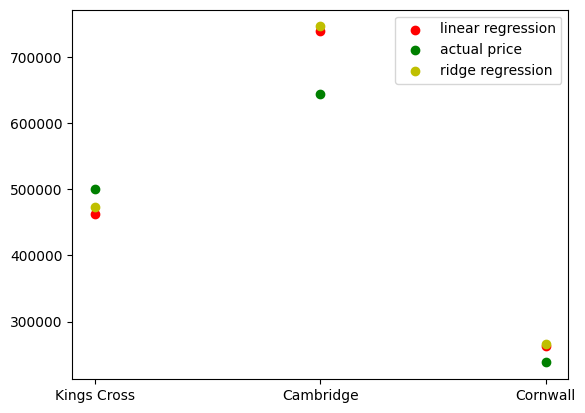

In [65]:
plt.xticks([0,1,2], list(linear_predictions.keys()))
plt.scatter([0,1,2], [linear_predictions["Kings Cross"][0], linear_predictions["Cambridge"][0], linear_predictions["Cornwall"][0],], c='r', label='linear regression')
plt.scatter([0,1,2], [linear_predictions["Kings Cross"][1], linear_predictions["Cambridge"][1], linear_predictions["Cornwall"][1],], c='g', label='actual price')
plt.scatter([0,1,2], [ridge_predictions["Kings Cross"][0], ridge_predictions["Cambridge"][0], ridge_predictions["Cornwall"][0],], c='y', label='ridge regression')
plt.legend()
plt.show()

## Large Language Models

If you used LLMs to generate or fix code in this assignment (recommended), briefly summarise the process and prompts you used. What do you think of the integration of LLMs in the data science pipeline?

I primarily made use of LLMs during this assignment as an API exploration tool. This was particularly helpful for some of the python libraries that are not very-well documented such as statsmodels but it also proved helpful in terms of helping me to write code to generate plots of the data in the way I wanted using matplotlib. I would normally search things on google first and if I dindn't find an answer I was satisfied with I would express my problem completely naturally to the LLM and I was surprised at how well it could understand my intention even when it wasn't prased in the clearest way. That being said I did dind that the LLM struggled with prompts that were more open ended (e.g. what are typical approaches to extracting features from a dataset that is highly correlated). I think that LLMs can be an extremely useful tool when used appropriately however, I would be using them in situations where more nuance is typically required such as feature discovery as I found that they struggle in these domains. One should also be weary of the fact that an LLM can 'hallucinate' and tell you things that aren't true and so you should also make sure to check other sources before just commiting to what an LLM has told you.

### FAQs

- Why is my connection to the AWS server intermittent?

If you are using Google Colab, online notebooks may throttle your code or time you out. Local Python code is recommended for tasks for large data management in the database.

- Why do SQL queries take a long time?

Some queries legitimately take a long time, even when done right. We suggest indexing your tables to speed up queries over your database. You can index tables by different columns depending on the queries you want to perform. For example, indexing the tables by `postcode` could speed up the join in Task D. More information regarding indexing in MariaDB is available [here](https://mariadb.com/kb/en/getting-started-with-indexes/).

You may also want to consider creating single or multi-column indices on coordinates, or any other properties you use to select data, if that step is taking a long time.

If your new queries seem stuck, try running `SHOW FULL PROCESSLIST`, and `KILL` any stuck processes.

- Why are table populating processes taking so long?

Again populating the database can take long. However, be careful if you are indexing the tables. You should populate data before indexing. Insert operations are impacted by indexes as they are updated with each new row inserted into the table.

- Some other questions are answered in [this reddit forum](https://www.reddit.com/r/CST_ADS/) or [this doc](https://docs.google.com/document/d/1GfDROyUW8HVs2eyxmJzKrYGRdVyUiVXzPcDfwOO8wX0/edit?usp=sharing). Feel free to also ask about anything that comes up.